In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ
#nltk.download('popular')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\Park\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Park\AppData\Local\Temp\ipykernel_24352\2164247218.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Train_rev1.csv')

In [3]:
selected_df = df.sample(n=2500,random_state = 815)


In [4]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return ADJ
    elif tag.startswith('V'):
        return VERB
    elif tag.startswith('N'):
        return NOUN
    elif tag.startswith('R'):
        return ADV
    else:
        return NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return text

In [5]:
import string
selected_df['Description'] = selected_df['FullDescription'].apply(clean_text)

In [6]:
percentile_75 = selected_df['SalaryNormalized'].quantile(0.75)
selected_df['salary_category'] = selected_df['SalaryNormalized'].apply(lambda x: 'high' if x > percentile_75 else 'low')
selected_df['salary_encoded'] = selected_df['salary_category'].map({'high': 1, 'low': 0})


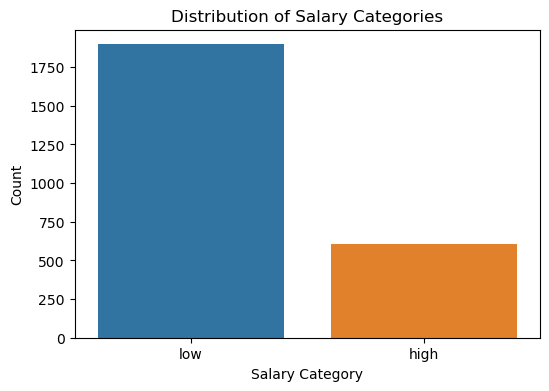

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='salary_category', data=selected_df)
plt.title('Distribution of Salary Categories')
plt.xlabel('Salary Category')
plt.ylabel('Count')
plt.show()

In [8]:
import nltk
from nltk import NaiveBayesClassifier
from nltk.classify.util import accuracy
import random

tokenized_description = [nltk.word_tokenize(desc.lower()) for desc in selected_df['Description']]

all_words = nltk.FreqDist(w for description in tokenized_description for w in description)
word_features = list(all_words)[:2000]
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

featuresets = [(document_features(d), c) for (d,c) in zip(tokenized_description, selected_df['salary_category'])]

random.seed(815)
random.shuffle(featuresets)
split = int(len(featuresets) * 0.8)

train_set, test_set = featuresets[:split], featuresets[split:]
classifier = nltk.NaiveBayesClassifier.train(train_set)


accuracy_2000 = nltk.classify.accuracy(classifier, test_set)
classifier.show_most_informative_features(40)
print('The accuracy is the model is',accuracy_2000)


Most Informative Features
     contains(architect) = True             high : low    =     20.3 : 1.0
       contains(allegis) = True             high : low    =     15.4 : 1.0
    contains(restaurant) = True              low : high   =     13.5 : 1.0
        contains(repair) = True              low : high   =     11.2 : 1.0
            contains(we) = True              low : high   =     10.5 : 1.0
       contains(teacher) = True              low : high   =      9.2 : 1.0
           contains(nmc) = True              low : high   =      9.0 : 1.0
     contains(assistant) = True              low : high   =      8.8 : 1.0
 contains(collaborative) = True             high : low    =      8.8 : 1.0
   contains(hospitality) = True              low : high   =      8.6 : 1.0
         contains(scrum) = True             high : low    =      8.5 : 1.0
       contains(invoice) = True              low : high   =      8.3 : 1.0
        contains(school) = True              low : high   =      8.3 : 1.0

The accuracy of the model is 79.2% using a list of the 2000 most frequent words in the overall description.

# Top 10 words that are most indicative of High Salary.

Architect: 20.3 times more likely to be associated with high salary.

Allegis: 15.4 times more likely to be associated with high salary.

Collaborative: 8.8 times more likely to be associated with high salary.

Scrum: 8.5 times more likely to be associated with high salary.

Instrumentation: 8.0 times more likely to be associated with high salary.

Transformation: 7.9 times more likely to be associated with high salary.

ACA: 7.4 times more likely to be associated with high salary.

Equity: 6.9 times more likely to be associated with high salary.

Cloud: 6.8 times more likely to be associated with high salary.

Analogue: 5.8 times more likely to be associated with high salary.

# Top 10 words that are most indicative of Low Salary.

Restaurant: 13.5 times more likely to be associated with low salary. 

Repair: 11.2 times more likely to be associated with low salary. 

We: 10.5 times more likely to be associated with low salary. 

Teacher: 9.2 times more likely to be associated with low salary. 

NMC: 9.0 times more likely to be associated with low salary. 

Assistant: 8.8 times more likely to be associated with low salary. 

Hospitality: 8.6 times more likely to be associated with low salary. 

Invoice: 8.3 times more likely to be associated with low salary. 

School: 8.3 times more likely to be associated with low salary. 

Kitchen: 7.9 times more likely to be associated with low salary.

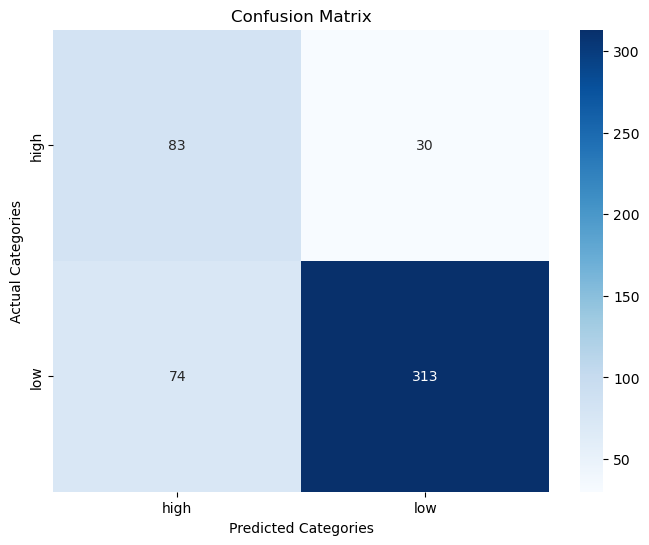

In [9]:
actual_categories = [c for (d, c) in test_set]

predicted_categories = [classifier.classify(d) for (d, c) in test_set]
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['high', 'low']

cm = confusion_matrix(actual_categories, predicted_categories, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Categories')
plt.ylabel('Actual Categories')
plt.show()


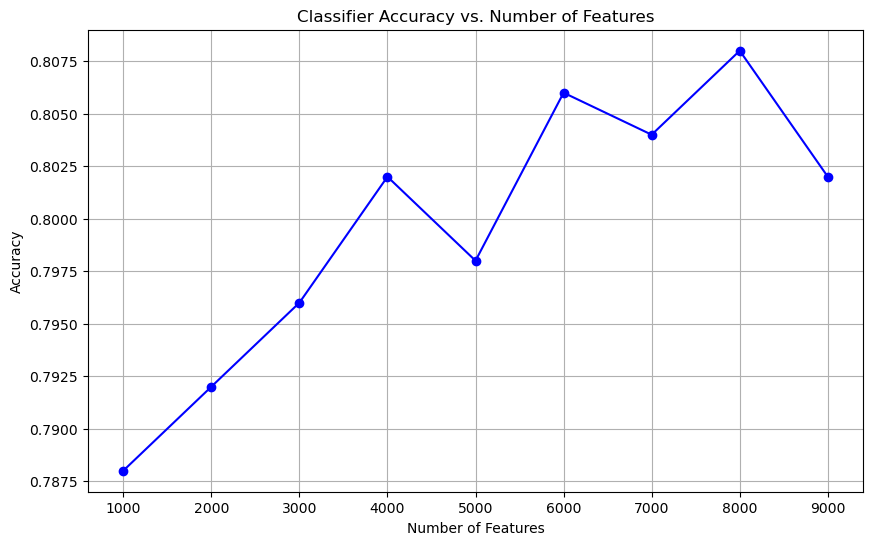

In [10]:
feature_num = np.arange(1000,10000,1000, dtype=int)  
accuracy = []

for num in feature_num:
    word_features = list(all_words)[:num]
    
    featuresets = [(document_features(d), c) for (d,c) in zip(tokenized_description, selected_df['salary_category'])]
    
    random.seed(815)
    random.shuffle(featuresets)
    
    split = int(len(featuresets) * 0.8)
    train_set, test_set = featuresets[:split], featuresets[split:]
    
    classifier = NaiveBayesClassifier.train(train_set)
    accuracy.append(nltk.classify.accuracy(classifier, test_set))

plt.figure(figsize=(10, 6))
plt.plot(feature_num, accuracy, marker='o', linestyle='-', color='b')
plt.title('Classifier Accuracy vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


To improve the accuracy of the Model, several effective strategies can be adopted.

Firstly, optimizing the number of features can enhance the accuracy of the model. By selecting the right number of features (list of the top words based on frequency), the model has access to a broader spectrum of information, potentially capturing more nuances related to salary distinctions.

Also, the dataset has an imbalance between the classes, which hampers the model's performance. By addressing this imbalance, the model's performance is likely to improve.

Applying a TF-IDF transformation to the job description can also be a potential solution to increase the model accuracy. TF-IDF emphasizes words that are particularly relevant to a document, thus helping to highlight the features that are most informative for the classification task.